# Practica 2 - CRI

En aquesta pràctica tenim com a objectiu assimilar conceptes clau com el guany d'informació, l'entropia i la discriminació de dades en grans conjunts. Es busca millorar la comprensió dels algoritmes d'inferència d'arbres com ID3 i C4.5 i la seva 
avaluació. L'ús de bases de dades ens permet aplicar aquests conceptes en situacions del món real, i l'ús de tècniques de validació ajuda a avaluar l'eficàcia dels models generats. En resum, la pràctica ofereix una oportunitat completa per entendre i aplicar aquests conceptes en el context de l'aprenentatge automàtic.

In [4]:
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

from ucimlrepo import fetch_ucirepo 

from anytree import Node, RenderTree

import warnings
warnings.filterwarnings("ignore")

## EXERCICI 1

### DECISION TREE CLASS

In [3]:
class DecisionTree:
    
    def __init__(self, criterion="entropy", max_depth=30):
        self.criterion = criterion 
        self.max_depth = max_depth
        
    """ FUNCIO QUE CREA ARBRE SEGONS EL CRITERI ESCOLLIT """
    def buildtree(self, df, tree = None, rf=False):
        if rf:
            if self.max_depth == 0:
                target = df.keys()[-1]
                most_common_class = df[target].value_counts().idxmax()
                return most_common_class
        if (self.criterion is "entropy"): # PARA ID3
            node = self.find_winner(df)
        elif (self.criterion is "gini"): # PARA C4.5
            node = self.find_best_attribute_c45(df)
        attvalue = np.unique(df[node])
        target = df.keys()[-1] # 'price range'
        if tree is None:
            tree = {}
            tree[node] = {}
        for value in attvalue:
            subtable = self.create_subtable(df,node,value)
            Clvalue, counts = np.unique(subtable[target], return_counts = True)
            if len(counts) == 1:
                tree[node][value] = Clvalue[0]
            else:
                tree[node][value] = self.buildtree(subtable)
        return tree
    
    """ 
    FUNCIONS PER L'ALGORISME ID3 on S es Target i A l'Atribut corresponent
    Information_gain(S, A) = Entropia(S)− Entropia(S, A) <- VALOR MAXIM
    """
    def find_winner(self, df):
        information_gain = []
        for key in df.keys()[:-1]:
            information_gain.append(self.find_entropy(df) - self.find_entropy_attribute(df, key))
        return df.keys()[:-1][np.argmax(information_gain)] # MAX
    
    def find_entropy(self, df):
        target = df.keys()[-1]
        values = df[target].unique()
        entropy = 0
        for value in values:
            prob = df[target].value_counts()[value]/len(df[target])
            entropy += -prob * np.log2(prob)
        return float(entropy)
    
    def find_entropy_attribute(self, df, attribute):
        target = df.keys()[-1]
        target_values = df[target].unique()
        attribute_values = df[attribute].unique()
        avg_entropy = 0
        for value in attribute_values:
            entropy = 0
            for value1 in target_values:
                num = df[(df[attribute] == value) & (df[target] == value1)].shape[0]
                den = df[df[attribute] == value].shape[0]
                prob = num/den
                entropy += -prob * np.log2(prob + 0.000001)
            avg_entropy += (den/len(df))*entropy
        return float(avg_entropy)
    
    def create_subtable(self, df, attribute, value):
        return df[df[attribute] == value].reset_index(drop = True)
     
    """ 
    FUNCIONS PER L'ALGORISME C4.5 on S es Target i A l'Atribut corresponent
    GainRatio(S,A) = Gain(S,A) / SplitInfo(S,A)
    """
    def find_best_attribute_c45(self, df):
        attributes = df.columns[:-1]
        best_gain_ratio = -10000000000000
        best_attr = None
        for attribute in attributes:
            gain_ratio = self.find_gain_ratio(df, attribute)
            if gain_ratio > best_gain_ratio:
                best_gain_ratio = gain_ratio
                best_attr = attribute
        return best_attr
        
    def find_gain_ratio(self, df, attribute):
        total_entropy = self.find_entropy(df)
        attribute_entropy = self.find_entropy_attribute(df, attribute)
        intrinsic_value = 0

        attribute_values = df[attribute].unique()
        for value in attribute_values:
            fraction = len(df[attribute][df[attribute] == value]) / len(df)
            intrinsic_value += -fraction * np.log2(fraction + np.finfo(float).eps)

        information_gain = total_entropy - attribute_entropy
        gain_ratio = information_gain / (intrinsic_value + np.finfo(float).eps)
        return gain_ratio
    
    """ Predict per evaluar dades """
    def predict(self, inst, tree):
        for node in tree.keys():
            value = inst[node]
            if value in tree[node]:
                tree = tree[node][value]
            elif 0 in tree[node]:
                tree = tree[node][0]
            elif 1 in tree[node]:
                tree = tree[node][1]
            elif 2 in tree[node]:
                tree = tree[node][2]
            prediction = 0
            if type(tree) is dict:
                prediction = self.predict(inst, tree)
            else:
                prediction = tree
        return prediction
    
    

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Jan\AppData\Local\Temp\ipykernel_2344\2588969713.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (self.criterion is "entropy"): # PARA ID3
C:\Users\Jan\AppData\Local\Temp\ipykernel_2344\2588969713.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif (self.criterion is "gini"): # PARA C4.5


### PRINT D'ARBRE

Utilitzem aquestes funcions per fer l'arbre generat per buildtree molt més llegible.

In [3]:
def is_numeric(value):
    return (
        isinstance(value, (int, float, complex)) or
        isinstance(value, np.integer) or
        (isinstance(value, np.ndarray) and value.dtype == np.int64)
    )

def print_dict_items(dictionary, parent, add):
    if isinstance(dictionary, dict):
        for key, value in dictionary.items():
            if (not is_numeric(key)):
                child = Node(add + " -> " + key, parent=parent)
                add = ""
            else:
                add = str(key)
                child = parent
            if isinstance(value, dict):
                print_dict_items(value, child, add)
            else:
                child2 = Node(add + " -> " + str(value), parent=child)
    else:
        print("hola")
        child = Node(add + " -> " + dictionary, parent=parent)

### Exploratory Dataset Analisis

In [5]:
# Lectura csv
df = pd.read_csv('train.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


En aquesta taula identifiquem dos tipus de dades: categòriques i continues. El nostre target és "price range" i la resta de dades les utilitzarem per l'entrenament del model.

Tot i que la majoria de dades són numeros, no per això significa que s'hagin de classificar com a tal. Moltes vegades, aquestes representen una codificació d'una variable categorica on, per exemple en el cas de la columna "blue", l'1 significa que és blau i el 0 significa que no ho és. És per això que cal distingir abans de discretitzar les dades continues, pero no obtenir mals resultats per intentar discretitzar una variable categorica que donaria com a resultat una columna de NaNs.

Abans de tot, comprovem que no hi hagi cap NaN a la base de dades. Si hi ha, fem un dropna(). Si no, no fem res.

In [5]:
print("La quantitat de NaNs a la nostra base de dades es: ", df.isna().sum().sum())

La quantitat de NaNs a la nostra base de dades es:  0


Com no hi ha cap missing value, no cal fer cap drop de cap fila.

El següent pas a realitzar es discretitzar les variables continues, excepte el target "price_range" que no s'ha de modificar. Separarem els dos tipus de categories i aplicarem pd.qcut a cadascuna de les columnes corresponents. Això ens permetra, com bé diu l'objectiu de la pràctica, aplicar els algorismes ID3 i C4.5 per a atributs categòrics.

In [6]:
# discretizar
df_qcut = df
categorical_columns = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
continuous_columns = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']

# Discretitzar variables contínues
for column in continuous_columns:
    df_qcut[column] = pd.qcut(df_qcut[column], q=4, labels=False, duplicates='drop')
    
df_qcut.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,0,0,2,0,0,0,0,2,3,0,...,0,0,2,0,2,3,0,0,1,1
1,1,1,0,1,0,1,3,2,1,0,...,2,3,2,3,1,1,1,1,0,2
2,0,1,0,1,1,1,2,3,2,2,...,3,3,2,1,0,1,1,1,0,2
3,0,1,3,0,0,0,0,2,1,2,...,3,3,2,2,2,1,1,0,0,2
4,3,1,1,0,3,1,2,2,1,0,...,3,1,1,0,0,2,1,1,0,1


<Axes: >

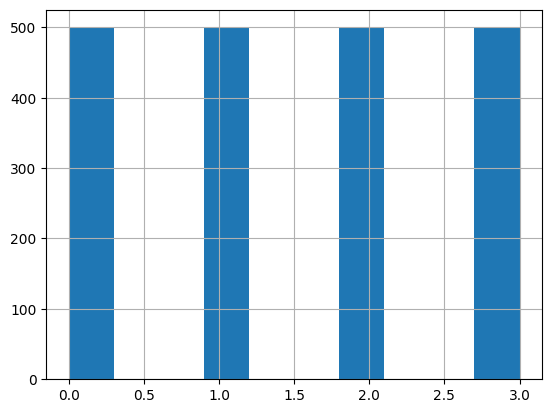

In [7]:
df_qcut['price_range'].hist()

Una vegada discretitzades les dades hem de fer el nostre model de Decision Tree. Utilitzem la classe creada anteriorment i les funcions per printar l'arbre.

In [6]:
tree = DecisionTree(criterion="gini")
constructed_tree = tree.buildtree(df_qcut)

root = Node("Root")
print_dict_items(constructed_tree, root, "")

for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))

Root
└──  -> ram
    ├── 0 -> px_width
    │   ├── 0 -> wifi
    │   │   ├── 0 -> fc
    │   │   │   ├── 0 -> battery_power
    │   │   │   │   ├── 0 -> 0
    │   │   │   │   ├── 1 -> 0
    │   │   │   │   ├── 2 -> px_height
    │   │   │   │   │   ├── 0 -> 0
    │   │   │   │   │   ├── 1 -> 0
    │   │   │   │   │   └── 2 -> 1
    │   │   │   │   └── 3 -> dual_sim
    │   │   │   │       ├── 0 -> 1
    │   │   │   │       └── 1 -> 0
    │   │   │   ├── 1 -> 0
    │   │   │   ├── 2 -> 0
    │   │   │   └── 3 -> 0
    │   │   └── 1 -> 0
    │   ├── 1 -> mobile_wt
    │   │   ├── 0 -> three_g
    │   │   │   ├── 0 -> battery_power
    │   │   │   │   ├── 0 -> 0
    │   │   │   │   ├── 1 -> 0
    │   │   │   │   ├── 2 -> 1
    │   │   │   │   └── 3 -> 0
    │   │   │   └── 1 -> 0
    │   │   ├── 1 -> 0
    │   │   ├── 2 -> three_g
    │   │   │   ├── 0 -> 0
    │   │   │   └── 1 -> px_height
    │   │   │       ├── 0 -> talk_time
    │   │   │       │   ├── 0 -> 0
    │   │   │       │   

### CROSS VALIDATION

Per al Cross Validation el que farem serà un KFold i utilitzarem la mètrica accuracy perquè, com hem observat abans, el dataset esta totalment balancejat, per tant, és lo ideal.

Com no es model totalment extret de la llibreria haurem de implementar-ho nosaltres, el com es fan les particions i les prediccions bàsicament. Dividim el conjunt de dades en k particions o "folds". Realitzem k iteracions, utilitzant cada fold com a conjunt de prova una vegada i els k-1 folds restants com a conjunt d'entrenament.

In [10]:
def cross_validation(df_qcut, X, y, tree, n_splits=5, random_state=42, shuffle=True):
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    predictions = []
    y_tests = []
    accuracy_mean = []

    for i, (train_index, test_index) in enumerate(kf.split(df_qcut)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train = pd.concat([X_train, y_train], axis=1)
        constructed_tree = tree.buildtree(train)
        y_tests.extend(y_test)
        predicts = []
        for idx, fila in X_test.iterrows():
            dict_fila = fila.to_dict()
            predicts.append(tree.predict(fila, constructed_tree))
        predictions.extend(predicts)

        accuracy = accuracy_score(y_test, predicts)
        accuracy_mean.append(accuracy)

        print('Accuracy para el fold ', {i+1}, ' : ', {accuracy})
        
    return predictions, y_tests, accuracy_mean
        
X = df_qcut.drop("price_range", axis=1)
y = df_qcut["price_range"]

treeCV = DecisionTree(criterion="entropy")
predictions, y_tests, accuracy_mean = cross_validation(df_qcut, X, y, treeCV)


Accuracy para el fold  {1}  :  {0.6975}
Accuracy para el fold  {2}  :  {0.735}
Accuracy para el fold  {3}  :  {0.675}
Accuracy para el fold  {4}  :  {0.705}
Accuracy para el fold  {5}  :  {0.6825}


Accuracy total:  0.6990000000000001
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       500
           1       0.60      0.62      0.61       500
           2       0.57      0.58      0.58       500
           3       0.80      0.78      0.79       500

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



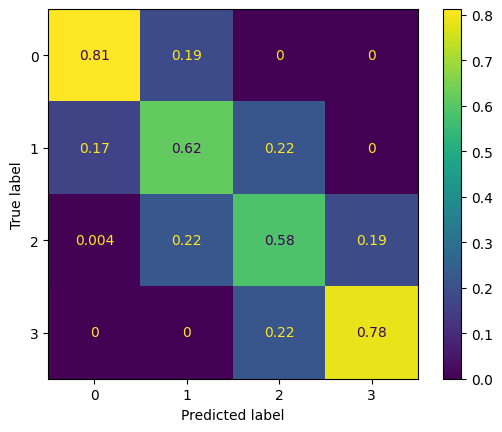

In [11]:
total_accuracy = sum(accuracy_mean)/len(accuracy_mean)
print("Accuracy total: ", total_accuracy)
report = classification_report(y_tests, predictions)
print(report)
confusion = ConfusionMatrixDisplay.from_predictions(y_tests, predictions, normalize='true')

Com podem veure, ens dona un accuracy de 0.7 que equival a un 70%. Es un accuracy bastant baix, però si fem el següent podem veure que no s'ajunya molt de un valor correcte.

In [11]:
from sklearn.model_selection import train_test_split
X = df.drop('price_range', axis=1)
y = df['price_range']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
model = DecisionTreeClassifier(criterion='entropy')  # Pots canviar a 'gini' per C4.5 amb Gini
score = cross_val_score(model, X, y, cv=5)
print(f"Accuracy scores for each fold: {score}")
print(f"Mean cross-validation accuracy: {score.mean()}")

model.fit(X_train, y_train)

Accuracy scores for each fold: [0.735  0.72   0.7225 0.69   0.71  ]
Mean cross-validation accuracy: 0.7155


DecisionTreeClassifier(criterion='entropy')

Com veiem, el valor que dona el model DecisionTreeClassifier creat a partir de la llibreria sklearn dona un valor proper al que ens dona a nosaltres, per tant, podem concluir que és correcte a pesar de ser un valor baix.

Em de dir que ens centrem bastant en l'accuracy, que és la mètrica utilitzada per aquesta comparació. Això és més que res pel fet de que mètriques com f1-score o recall no ens acaben d'interessar, ja que el que volem és predir el millor possible totes les classes, no centrar-nos en una únicament.

## EXERCICI 2

Com en el nostre dataset, que correspon amb el mobile price classification, no tenim cap valor null, hem agafat altre dataset que en aquest cas és el Heart Disease. En aquest dataset farem el tractament de NaNs que correspon.

Primer, hem d'importar el dataset.

In [12]:
heart_disease = fetch_ucirepo(id=45) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

Una vegada importat, podem veure amb el info() on trobem NaNs i el tipus de dades al que correspon.

In [13]:
df_heart_disease_X = pd.DataFrame(X) 
df_heart_disease_y = pd.DataFrame(y)
df_heart_disease = pd.concat([df_heart_disease_X, df_heart_disease_y], axis=1)

print(df_heart_disease.info())
df_heart_disease.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB
None


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [14]:
df_heart_disease.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Per aquest tractament, farem un fill de NaNs a partir de la moda. Considerem que és el més apropiat tant per la categoria 'ca' que es númeric com per 'thal' que es categoric. Aquestes dues columnes tenen dades discretes, és a dir, sense decimals. Per tant, si fiquem un valor amb decimals que correspon a fer un fill amb la mitjana, per exemple, no seria del tot coherent per nosaltres. Es per això que hem decidit omplenar amb la moda.

In [15]:
moda1 = df_heart_disease['ca'].mode()[0]
moda2 = df_heart_disease['thal'].mode()[0]

# Llena los NaN con la moda
df_heart_disease['ca'].fillna(moda1, inplace=True)
df_heart_disease['thal'].fillna(moda2, inplace=True)

df_heart_disease.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.722772,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.938383,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


## EXERCICI 3

Per aquest apartat, hem de fer un tractament d'arguments continus. Farem servir l'algorisme vist a classe que tracta de fer particions binaries.

Primer fem una ordenació ascendent dels valors de les columnes. Fem una particio binaria a cada punt mig i per cadascun d'aquest calculem la entropia de l'arbre parcial (l'entropia del punt cap a l'esquerra i del punt cap a la dreta per dir-ho d'una forma). Després seleccionem la millor partició a partir de la ganancia.

Cal dir que, encara que ja teniem una funció find_entropy a la nostre classe de Decicision Tree, per fer el procés més simple tornarem a crearla per utilitzarla al nostre algorisme.

In [16]:
def find_entropy(df, target_column):
    values = df[target_column].unique()
    entropy = 0
    for value in values:
        prob = df[target_column].value_counts()[value]/len(df[target_column])
        entropy += -prob * np.log2(prob)
    return float(entropy)

def mejor_punto_particion(df, columna_continua, columna_objetivo):
    valores_ordenados = sorted(df[columna_continua].unique())
    mejor_punto = None
    mejor_ganancia = float('-inf')

    for i in range(len(valores_ordenados) - 1):
        punto_medio = (valores_ordenados[i] + valores_ordenados[i + 1]) / 2
        grupo1 = df[df[columna_continua] <= punto_medio]
        grupo2 = df[df[columna_continua] > punto_medio]
        entropia1 = find_entropy(grupo1, columna_objetivo)
        entropia2 = find_entropy(grupo2, columna_objetivo)
        ganancia = - (entropia1 + entropia2) # Minimiza la entropía total

        if ganancia > mejor_ganancia:
            mejor_ganancia = ganancia
            mejor_punto = punto_medio

    return mejor_punto

# Aplicar la funció de quatre particions a les columnes desitjades
def discretizar_columna(df, columna, punto_particion):
    # Discretiza los valores basados en el punto de partición
    return df[columna].apply(lambda x: 0 if x <= punto_particion else 1)

def discretizar_dataset(df, columnas_continuas, columna_objetivo):
    for columna in columnas_continuas:
        punto_particion = mejor_punto_particion(df, columna, columna_objetivo)
        df[columna] = discretizar_columna(df, columna, punto_particion)
    return df

In [17]:
continuous_columns = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']

columna_objetivo = "price_range"  # Reemplaza con la columna objetivo

df_discretizado = discretizar_dataset(df, continuous_columns, columna_objetivo)
print(df_discretizado)

df_discretizado.head()

      battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
0                 0     0            0         0   0       0           0   
1                 0     1            0         1   0       1           1   
2                 0     1            0         1   0       1           1   
3                 0     1            1         0   0       0           0   
4                 1     1            0         0   1       1           1   
...             ...   ...          ...       ...  ..     ...         ...   
1995              0     1            0         1   0       1           0   
1996              1     1            1         1   0       0           1   
1997              1     0            0         1   0       1           1   
1998              1     0            0         0   0       1           1   
1999              0     1            0         1   0       1           1   

      m_dep  mobile_wt  n_cores  ...  px_height  px_width  ram  sc_h  sc_w  \
0        

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,1
1,0,1,0,1,0,1,1,0,1,0,...,0,1,1,1,0,0,1,1,0,2
2,0,1,0,1,0,1,1,1,1,1,...,1,1,1,0,0,0,1,1,0,2
3,0,1,1,0,0,0,0,0,1,1,...,1,1,1,1,0,0,1,0,0,2
4,1,1,0,0,1,1,1,0,1,0,...,1,0,1,0,0,0,1,1,0,1


Com veiem al dataset, ara les dades estan discretitzades. No obstant, no de la mateixa manera que ho fa el qcut perquè a aquell li van demanar que ho fes en quatre particions, mentre que per aquest només en dues. 

## EXERCICI 4


Per aquest cas, se'ns demana fer la implementació del model Random Forest.  
Hem decidit fer una classe RandomForest la qual tindrà com a atributs el nombre d'arbres, la profunditat màxima i un diccionari amb el número d'arbres que es vulguin crear.

In [11]:
class RandomForest:
    def __init__(self, n_trees=100, min_samples_split=2, max_depth=30):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = {}

    def bootstrap_sample(self, df):
        return df.sample(n=len(df), replace=True)

    def fit(self, df):
        tree = DecisionTree(criterion="entropy", max_depth=self.max_depth)
        for _ in range(self.n_trees):
            sample = self.bootstrap_sample(df)
            constructed_tree = tree.buildtree(sample)
            self.trees[tree] = constructed_tree

    def predict(self, sample):
        predictions = []
        for _, row in sample.iterrows():
            tree_predictions = [k.predict(row, v) for k,v in self.trees.items()]
            predictions.append(max(set(tree_predictions), key=tree_predictions.count))
        return np.array(predictions)

X = df_qcut.drop(columns=['price_range'])
y = df_qcut['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

train = pd.concat([X_train, y_train], axis=1)

trained_forest = RandomForest(n_trees=5, min_samples_split=2, max_depth=30)
trained_forest.fit(train)
predictions = trained_forest.predict(X_test)

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       161
           1       0.60      0.65      0.62       124
           2       0.59      0.61      0.60       155
           3       0.79      0.76      0.77       160

    accuracy                           0.71       600
   macro avg       0.71      0.71      0.71       600
weighted avg       0.72      0.71      0.72       600



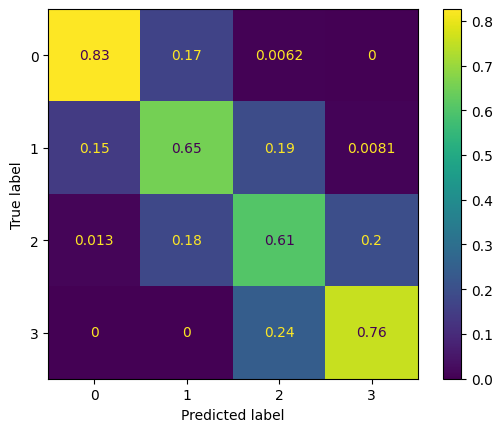

In [12]:
report = classification_report(y_test, predictions)
print(report)
confusion = ConfusionMatrixDisplay.from_predictions(y_test, predictions, normalize='true')

#### CROSS VALIDATION RF

En aquesta part farem una validació del nostre RandomForest com hem fet anteriorment amb el DecisionTree.

In [13]:
def cross_validation_rf(df_qcut, X, y, rf, n_splits=5, random_state=42, shuffle=True):
    kf = KFold(n_splits=5)
    predictions = []
    y_tests = []
    accuracy_mean = []

    for i, (train_index, test_index) in enumerate(kf.split(df_qcut)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train = pd.concat([X_train, y_train], axis=1)
        rf.fit(train)
        predicts = rf.predict(X_test)
        y_tests.extend(y_test)
        predictions.extend(predicts)

        accuracy = accuracy_score(predicts, y_test)
        accuracy_mean.append(accuracy)

        print('Accuracy para el fold ', {i+1}, ' : ', {accuracy})
        rf.trees = {}
        
    return predictions, y_tests, accuracy_mean
        
X = df_qcut.drop("price_range", axis=1)
y = df_qcut["price_range"]

RFCV = RandomForest(n_trees=5, min_samples_split=2, max_depth=30)
predictions, y_tests, accuracy_mean = cross_validation_rf(df_qcut, X, y, RFCV)


Accuracy para el fold  {1}  :  {0.755}
Accuracy para el fold  {2}  :  {0.6725}
Accuracy para el fold  {3}  :  {0.6825}
Accuracy para el fold  {4}  :  {0.72}
Accuracy para el fold  {5}  :  {0.67}


              precision    recall  f1-score   support

           0       0.82      0.80      0.81       500
           1       0.60      0.60      0.60       500
           2       0.58      0.60      0.59       500
           3       0.81      0.79      0.80       500

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



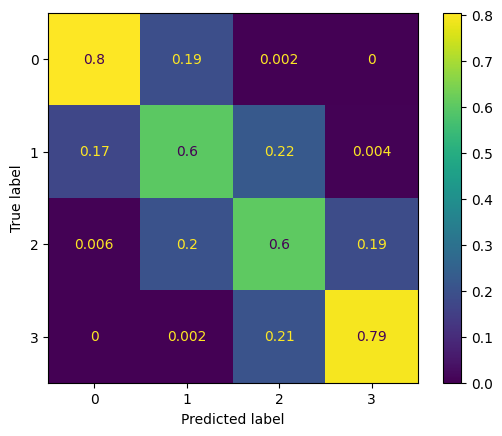

In [14]:
report = classification_report(y_tests, predictions)
print(report)
confusion = ConfusionMatrixDisplay.from_predictions(y_tests, predictions, normalize='true')

##### CONCLUSIONS

Podem observar dels resultats obtinguts que els resultats del RandomForest en comparació amb el DecisionTree són una mica millors, encara que no hi ha una gran diferència.  
 Això era d'esperar ja que el RF bàsicament fa molts DecisionTrees i després es queda amb el resultat més votat per a cada Tree. Molts cops és útil per a evitar overfitting en cas que el arbre creat s'adapti massa a les dades i no generalitzi bé, aleshores la votació entre tots els arbres fa que no poguem tenir aquesta situació, encara que amb el nostre dataset no en teniem quan feiem el DecisionTree. 